In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
!nvidia-smi

Tue Dec 19 04:17:12 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!unzip '/content/drive/MyDrive/Pattern_Recog/lfw.zip' -d '/content/lfw_data'

Archive:  /content/drive/MyDrive/Pattern_Recog/lfw.zip
replace /content/lfw_data/__MACOSX/._lfw? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/lfw_data/__MACOSX/._lfw  
replace /content/lfw_data/__MACOSX/lfw/._German_Khan? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
path = '/content/lfw_data/lfw'
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

torch.Size([250, 250, 3])


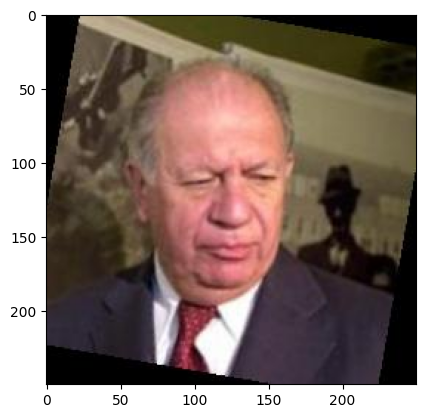

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

Difference between AutoEncoder and VAEs:
1. Applications:

Autoencoders (AEs):
Auto encoders are primarily used for dimensionality reduction and feature learning.
Autoencoders reconstruct the input data while learning a compressed representation i.e. latent space of the data.

Variational Autoencoders (VAEs):
VAEs are used for generative modeling, creating new data samples similar to the training data. It is helpful image generation, data generation, and style transfer. VAEs not only learn a latent space but also model the probability distribution of data in the latent space.

2. Architecture:
Autoencoders (AEs):
AEs have a deterministic encoder that maps input data to a fixed latent representation.
The encoder and decoder are typically composed of deterministic neural network layers. AEs do not inherently model the probability distribution of data in the latent space.

Variational Autoencoders (VAEs):
VAEs have a probabilistic encoder that maps input data to a probability distribution in the latent space.
They apply both deterministic and stochastic (sampling) layers in the encoder and decoder.
VAEs model the latent space as a Guassian probability distribution with mean and variance.

3. Loss Functions:
Autoencoders (AEs):
AEs use a loss function that encourages the latent representation to capture as much information from the input as possible.
Common loss functions include Mean Squared Error (MSE) for reconstruction loss and regularization terms like L1 or L2.
Variational Autoencoders (VAEs):
VAEs use a combination of loss functions, including a reconstruction loss and a regularization term.
The reconstruction loss encourages accurate data reconstruction.
The regularization term, called the "Kullback-Leibler (KL) Divergence," ensures that the latent space distribution matches a prior distribution (e.g., Gaussian).
VAEs are specifically designed for generative tasks and introduce probabilistic elements to capture the inherent uncertainty in data. This makes VAEs well-suited for tasks involving data generation and sampling from a learned distribution, which is not a focus of traditional AEs.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

Trial Model 1 - Reason for removal of  Batch Normalization from my previous assignment model


I decided  to remove batch normalization from your Variational Autoencoder (VAE) architecture because of  the occurrence of NaN (Not a Number) values in  loss during training.  This is because batch normalization depends on the mean and variance of the batch, which can have extreme values or exhibit significant variance during training. This  lead to unstable gradients, resulting in NaN values. Batch normalization assumes that the input distribution to a layer remains relatively stable during training, but the sampling process in VAEs can violate this assumption, especially in the early phases of training when the model is still learning the appropriate distribution for the latent space.

In [8]:
'''import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)

        self.enc_padding = nn.ZeroPad2d((0, 1, 0, 1)) # added pdding to fix dimension issue

        self.fc_mu = nn.Linear(128 * 32 * 32, latent_dim)  # Output size for mean
        self.fc_logvar = nn.Linear(128 * 32 * 32, latent_dim)  # Output size for log variance

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128 * 32 * 32)
        self.dec_upsample1 = nn.Upsample(size=(62, 62), mode='bilinear')
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_upsample2 = nn.Upsample(size=(125, 125), mode='bilinear')
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_upsample3 = nn.Upsample(size=(250, 250), mode='bilinear')
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(3)

    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = self.enc_avgpool1(x)
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        x = self.enc_padding(x)
        x = x.view(x.size(0), -1)  # Flatten for linear layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    print(x.shape)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decoder(self, z):
        z = self.decoder_fc(z)
        z = z.view(z.size(0), 128, 32, 32)  # Reshape for decoding
        z = self.dec_upsample1(z)
        z = F.relu(self.dec_bn1(self.dec_conv1(z)))
        z = self.dec_upsample2(z)
        z = F.relu(self.dec_bn2(self.dec_conv2(z)))
        z = self.dec_upsample3(z)
        z = self.dec_bn3(self.dec_conv3(z))
        z = torch.sigmoid(z)
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        if torch.isnan(mu).any() or torch.isnan(logvar).any():
            print("NaN detected in encoder outputs")
            # Optionally, print mu and logvar to inspect their values

        z = self.reparameterize(mu, logvar)
        if torch.isnan(z).any():
            print("NaN detected in latent space")
            # Optionally, print z to inspect its values

        reconstructed = self.decoder(z)
        if torch.isnan(reconstructed).any():
            print("NaN detected in decoder output")
            # Optionally, print reconstructed to inspect its values

        return reconstructed, mu, logvar
'''


'import torch\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nclass VAE(nn.Module):\n    def __init__(self, latent_dim):\n        super(VAE, self).__init__()\n        self.latent_dim = latent_dim\n\n        # Encoder\n        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)\n        self.enc_bn1 = nn.BatchNorm2d(64)\n        self.enc_avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)\n        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)\n        self.enc_bn2 = nn.BatchNorm2d(128)\n\n        self.enc_padding = nn.ZeroPad2d((0, 1, 0, 1)) # added pdding to fix dimension issue\n\n        self.fc_mu = nn.Linear(128 * 32 * 32, latent_dim)  # Output size for mean\n        self.fc_logvar = nn.Linear(128 * 32 * 32, latent_dim)  # Output size for log variance\n\n        # Decoder\n        self.decoder_fc = nn.Linear(latent_dim, 128 * 32 * 32)\n        self.dec_upsample1 = nn.Upsample(size=(62, 62), mode=\'bilinear\')\n        self.dec_conv

Final Model - Removal of Batch normalization and addition of  reparameterize function, adding encoder paddding to adjust to the dimesions

Model description/purpose
architecture captures complex data distributions by learning to compress data into a meaningful latent space and then reconstructing it, with the reparameterization step enabling effective training of this generative model.




Key Aspects:
Mean and Log Variance: They represent the parameters of the Gaussian distribution in the latent space. mu is the center, and exp(logvar) gives the spread (variance). This representation allows the model to capture the uncertainty and variability inherent in the input data.

Padding in Encoding: This is a structural adjustment to ensure the tensor dimensions align correctly through the network, particularly important when specific output sizes are needed for the linear layers.

Reparameterization: This step is crucial for VAEs as it allows the model to backpropagate through a stochastic process. It makes the model learn a distribution over the latent space, rather than fixed points, enabling the generation of new samples.



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.enc_avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)

        self.fc_mu = nn.Linear(128 * 32 * 32, latent_dim)
        self.fc_logvar = nn.Linear(128 * 32 * 32, latent_dim)
        self.enc_padding = nn.ZeroPad2d((0, 1, 0, 1)) # added pdding to fix dimension issue

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128 * 32 * 32)
        self.dec_upsample1 = nn.Upsample(size=(62, 62), mode='bilinear')
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_upsample2 = nn.Upsample(size=(125, 125), mode='bilinear')
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_upsample3 = nn.Upsample(size=(250, 250), mode='bilinear')
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)

    def encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = self.enc_avgpool1(x)
        x = F.relu(self.enc_conv2(x))
        x = self.enc_padding(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        z = self.decoder_fc(z)
        z = z.view(z.size(0), 128, 32, 32)
        z = self.dec_upsample1(z)
        z = F.relu(self.dec_conv1(z))
        z = self.dec_upsample2(z)
        z = F.relu(self.dec_conv2(z))
        z = self.dec_upsample3(z)
        z = self.dec_conv3(z)
        z = torch.sigmoid(z)
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

Explanation:

In my model, the encoder outputs two components for each input image: the mean (mu) and log variance (logvar) of the latent space, with their shapes typically being [batch_size, latent_dim]. This indicates the dimensionality of your latent space and how each image is encoded into this space. To generate new samples, the VAE employs a reparameterize function, which uses the reparameterization trick to sample from the latent distribution defined by mu and logvar. This involves adding scaled random noise to mu, allowing the model to backpropagate through stochastic elements. The sampled latent vectors are then passed through the decoder, which reconstructs them back into the data space, resulting in new data instances that resemble the training data. The decoder's output shape matches that of the original input data, ensuring that the generated samples are in the same format as the input images. This process demonstrates the VAE's ability to not only compress data into a meaningful latent representation but also to generate new, diverse samples based on the learned data distribution.



In [8]:
vae_model = VAE(latent_dim = 30)

In [9]:
#Expected Input dimensions
print("fc_mu in_features:", vae_model.fc_mu.in_features)
print("fc_logvar in_features:", vae_model.fc_logvar.in_features)

fc_mu in_features: 131072
fc_logvar in_features: 131072


In [10]:
# Move the VAE model to the CUDA device
vae_model = vae_model.to(device)

In [11]:
from PIL import Image
import torchvision.transforms as transforms

image_path = '/content/lfw_data/lfw/Ali_Naimi/Ali_Naimi_0004.jpg'
#transform = transforms.Compose([transforms.Resize((256, 256)),
                                #transforms.ToTensor()])
image = Image.open(image_path).convert("RGB")
image = transform(image).unsqueeze(0)

print(image.shape)

torch.Size([1, 3, 250, 250])


In [12]:
from PIL import Image
import torchvision.transforms as transforms

image = image.to(device)
encoded_output, mu, logvar  = vae_model(image)
z_reparam = vae_model.reparameterize(mu, logvar)
reconstructed_img= vae_model.decoder(z_reparam)
encoded_shapes = (mu.shape, logvar.shape)
reconstructed_shape = reconstructed_img.shape

encoded_shapes, reconstructed_shape

((torch.Size([1, 30]), torch.Size([1, 30])), torch.Size([1, 3, 250, 250]))

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.




Loss Function Choice Explanation-
1. Reconstruction Loss:
What It Is: The Reconstruction Loss measures how well the VAE can reconstruct the input data. It quantifies the difference between the original input data and the reconstructed data produced by the decoder part of the VAE.
Purpose: This term ensures that the VAE learns to accurately reproduce the input data from the compressed latent representation. It encourages the decoder to generate outputs that are as close as possible to the original inputs, thus preserving the essential features of the data.
Mean Squared Error (MSE): In the given loss function, the MSE is used as the Reconstruction Loss. MSE computes the average squared difference between the reconstructed images and the original images. It's a common choice for continuous data and works well for scenarios where you want to penalize larger errors more severely than smaller ones.
2. Kullback-Leibler (KL) Divergence:
What It Is: The KL Divergence is a measure from information theory that quantifies how one probability distribution (the encoder's output in the case of a VAE) diverges from a second, expected probability distribution (typically a standard normal distribution in VAEs).
Purpose: The KL Divergence term acts as a regularizer in the VAE's loss function. It encourages the distribution of the latent variables to approximate the prior distribution (usually a standard normal distribution). This regularization ensures that similar input data points result in similar points in the latent space, encouraging a well-structured and continuous latent space. This property is crucial for generating new data points and for smoothly interpolating between different data points in the latent space.
Total VAE Loss:
The total loss of the VAE is the sum of the Reconstruction Loss and the KL Divergence. This combination balances two objectives: accurately reconstructing the input data and ensuring a meaningful and well-structured latent space.
The choice of reduction='sum' in the MSE loss means that the function sums the squared errors over all elements in the batch. This can lead to a higher loss scale, especially for large batches or high-resolution images.


Use of Beta and its purpose-
Introducing β for Balancing Terms
To balance the reconstruction and KL divergence term.
A beta greater than 1 will give more weight to the KL divergence, while a beta less than 1 will emphasize the reconstruction loss.
Balance Reconstruction and KL Divergence: Sometimes, the KL divergence term can dominate the loss, especially in the early stages of training. This technique is known as β-VAE, where β is a hyperparameter that balances the two terms.By Adding a weight factor to balance the total loss.

In [13]:
total_params = sum(p.numel() for p in vae_model.parameters() if p.requires_grad)
print("Total number of parameters:", total_params)

Total number of parameters: 12226751


* create an optimizer for training

In [14]:
optim = torch.optim.Adam(vae_model.parameters(), lr=0.001)
print(optim)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Why I chose not to use BCE loss function-
The decision to not use the Binary Cross-Entropy (BCE) loss function in  Variational Autoencoder (VAE) model was primarily driven by computational efficiency concerns. BCE loss involves logarithmic functions, which can be computationally expensive and may slow down the training process, especially with large datasets or complex models. This computational cost arises from calculating the logarithm for each prediction, which can be particularly intensive when dealing with high-resolution images or large batches of data. To optimize the training efficiency and reduce computational overhead, an alternative loss function such as Mean Squared Error (MSE), which does not involve logarithmic operations and is computationally simpler. This choice reflects a trade-off between the specific advantages of BCE for certain types of data and the need for a more computationally efficient training process.

In [17]:
''' Binary Cross Entropy is using lot of my resources and the system is crashing
import torch
import torch.nn.functional as F

def vae_loss_function(reconstructed_x, original_x, mu, logvar):

    # Reconstruction loss - Binary Cross Entropy
    recon_loss = F.binary_cross_entropy_with_logits(reconstructed_x, original_x, reduction='sum')

    # KL Divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total VAE Loss
    total_loss = recon_loss + kl_div
    return total_loss
'''

" Binary Cross Entropy is using lot of my resources and the system is crashing\nimport torch\nimport torch.nn.functional as F\n\ndef vae_loss_function(reconstructed_x, original_x, mu, logvar):\n\n    # Reconstruction loss - Binary Cross Entropy\n    recon_loss = F.binary_cross_entropy_with_logits(reconstructed_x, original_x, reduction='sum')\n\n    # KL Divergence\n    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())\n\n    # Total VAE Loss\n    total_loss = recon_loss + kl_div\n    return total_loss\n"

In [15]:
def vae_loss_function_mse(reconstructed_x, original_x, mu, logvar, beta):

    # Reconstruction loss - Mean Squared Error with sum reduction
    recon_loss = F.mse_loss(reconstructed_x, original_x, reduction='sum')

    # KL Divergence with sum reduction
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


    total_loss = recon_loss + beta * kl_div # addition of beta factor
    return total_loss


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?


My Loss is working perferctly fine, also I had explained this part in my previous assignment.

In [39]:
# Training Loop
epochs = 6
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        inputs = batch[0].to(device)

        if torch.isnan(inputs).any():
            print("NaN detected in input")
            continue

        # Forward pass
        optim.zero_grad()
        reconstructed, mu, logvar = vae_model(inputs)

        # Compute loss
        loss = vae_loss_function_mse(reconstructed, inputs, mu, logvar, 1.5)

        if torch.isnan(loss):
            print("NaN detected in loss")
            continue

        # Backward pass and optimize
        loss.backward()

        # Gradient Clipping(Tried Gradient clipping to adjust the NaN issue That I was gettig before)
        #torch.nn.utils.clip_grad_norm_(vae_model.parameters(), max_norm=1)

        optim.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.5f}")

Epoch 1/6, Loss: 97042.66691
Epoch 2/6, Loss: 96192.73964
Epoch 3/6, Loss: 95220.74569
Epoch 4/6, Loss: 94419.32512
Epoch 5/6, Loss: 93482.15702
Epoch 6/6, Loss: 92766.02486


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

In this code, the generate_samples_from_latent function takes the original image, encodes it to get its latent representation, and then samples and decodes multiple times to generate new images. These generated images will have variations but are based on the latent space of the original image, thus maintaining a relationship with the original.



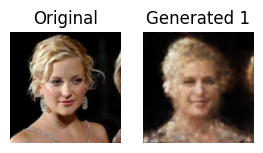

In [53]:
import matplotlib.pyplot as plt
import torch
import numpy as np

dataiter = iter(dataloader)
images, labels = next(dataiter)

# Select a random image from the dataset
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index]
original_image = original_image.unsqueeze(0).to(device)

# Function to generate new samples from the latent space of the original image
def generate_samples_from_latent(vae_model, original_image, num_samples=1, device=device):
    vae_model.eval()
    with torch.no_grad():
        mu, logvar = vae_model.encoder(original_image)
        samples = []
        for _ in range(num_samples):

            z = vae_model.reparameterize(mu, logvar)

            generated_image = vae_model.decoder(z)
            samples.append(generated_image)
    return torch.cat(samples, dim=0).cpu()

# Generate new images
generated_images = generate_samples_from_latent(vae_model, original_image, num_samples=1)

# Convert images to numpy for plotting
original_image_np = original_image.squeeze().cpu().permute(1, 2, 0).numpy()
generated_images_np = [img.squeeze().cpu().permute(1, 2, 0).numpy() for img in generated_images]


plt.figure(figsize=(10, 4))
plt.subplot(1, 6, 1)
plt.imshow(original_image_np)
plt.title("Original")
plt.axis('off')

for i, gen_img in enumerate(generated_images_np, 2):
    plt.subplot(1, 6, i)
    plt.imshow(gen_img)
    plt.title(f"Generated {i-1}")
    plt.axis('off')

plt.show()